In [34]:
# Import necessary libraries
import pandas as pd
import re
import nltk
from docx import Document
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download NLTK resources (only needed once)
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords, stemmer, and lemmatizer
stop_words = set(stopwords.words("english"))
# Extend stopwords to exclude too-common, non-informative words in this dataset
custom_stopwords = {
    'episode', 'show', 'season', 'watch', 'series', 'one', 'two', 'first',
    'second', 'still', 'even', 'thing', 'take', 'make', 'get', 'say', 'want', 'need', 'see', 'come', 'go', 'time',
    'minute', 'start', 'end', 'bit', 'lot', 'really', 'pretty', 'much', 'well',
    'wait', 'back', 'next', 'return', 'character', 'people', 'person', 'episod'}
stop_words.update(custom_stopwords)
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Define a function to clean and normalize text
def clean_text(text):
    # Convert to lowercase
    text = str(text).lower()
    # Remove special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    # Apply stemming and lemmatization
    tokens = [lemmatizer.lemmatize(stemmer.stem(t)) for t in tokens]
    return ' '.join(tokens)

# Define a function to read text from a Word document
def extract_docx_comments(path):
    doc = Document(path)
    return [p.text.strip() for p in doc.paragraphs if p.text.strip()]

# Load high-rated and low-rated episode reviews
high_comments = extract_docx_comments("Highest rated Episode Comments.docx")
low_comments = extract_docx_comments("Least rated Episode Comments.docx")

# Combine into one DataFrame
df = pd.DataFrame({
    "review": high_comments + low_comments,
    "group": ["high"] * len(high_comments) + ["low"] * len(low_comments)
})

# Clean the reviews
df["cleaned"] = df["review"].apply(clean_text)


[nltk_data] Downloading package punkt_tab to D:\BA\Foundation of
[nltk_data]     ba\python\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to D:\BA\Foundation of
[nltk_data]     ba\python\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to D:\BA\Foundation of
[nltk_data]     ba\python\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
# Use TextBlob to calculate polarity and subjectivity for each review
from textblob import TextBlob

df["polarity"] = df["cleaned"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["subjectivity"] = df["cleaned"].apply(lambda x: TextBlob(x).sentiment.subjectivity)


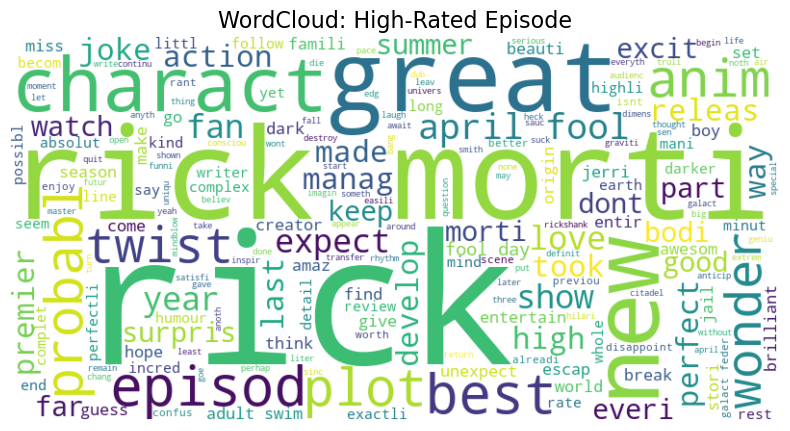

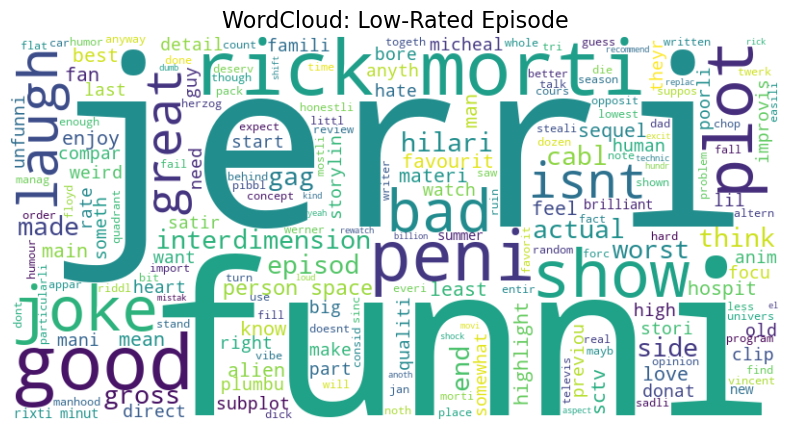

In [38]:
# Visualize the most frequent words in each group using WordCloud
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Generate word clouds for high- and low-rated reviews
plot_wordcloud(" ".join(df[df["group"] == "high"]["cleaned"]), "WordCloud: High-Rated Episode")
plot_wordcloud(" ".join(df[df["group"] == "low"]["cleaned"]), "WordCloud: Low-Rated Episode")


In [52]:
# Extract top keywords using TF-IDF (term frequency–inverse document frequency)
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_keywords(corpus, top_n=15):
    vectorizer = TfidfVectorizer(max_features=500)
    X = vectorizer.fit_transform(corpus)
    tfidf_scores = X.toarray().mean(axis=0)
    keywords = pd.Series(tfidf_scores, index=vectorizer.get_feature_names_out())
    return keywords.sort_values(ascending=False).head(top_n)
# save TF-IDF outcomes
keywords_high = get_top_keywords(df[df["group"] == "high"]["cleaned"])
keywords_low = get_top_keywords(df[df["group"] == "low"]["cleaned"])

# Print top keywords for each group
print("Top keywords (High-Rated):")
print(get_top_keywords(df[df["group"] == "high"]["cleaned"]))

print("\nTop keywords (Low-Rated):")
print(get_top_keywords(df[df["group"] == "low"]["cleaned"]))


Top keywords (High-Rated):
rick       0.110833
morti      0.065729
love       0.047331
best       0.046404
plot       0.042074
anim       0.039295
whole      0.038918
rate       0.038807
great      0.038208
highli     0.036228
like       0.033640
episod     0.032699
charact    0.031225
fan        0.030786
made       0.029578
dtype: float64

Top keywords (Low-Rated):
enjoy     0.057336
jerri     0.054440
great     0.053575
funni     0.050755
worst     0.050170
morti     0.049055
hilari    0.049030
good      0.047840
like      0.046048
bad       0.045761
rick      0.044091
sequel    0.043605
show      0.043333
hospit    0.038399
best      0.038114
dtype: float64


In [62]:

import seaborn as sns
import matplotlib.pyplot as plt

def plot_keywords_scatter(keywords, title, color):
    # pick top10 keywords
    top_keywords = keywords.head(10).sort_values(ascending=False)
    df_keywords = top_keywords.reset_index()
    df_keywords.columns = ['Keyword', 'TF-IDF']
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_keywords, x="TF-IDF", y="Keyword", s=200, color=color, edgecolor='black')
    
    # add keywords
    for i in range(df_keywords.shape[0]):
        plt.text(
            df_keywords['TF-IDF'][i] + 0.001, 
            df_keywords['Keyword'][i], 
            df_keywords['Keyword'][i],
            verticalalignment='center',
            fontsize=11
        )
    
    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel("TF-IDF Score", fontsize=12)
    plt.ylabel("Keyword", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


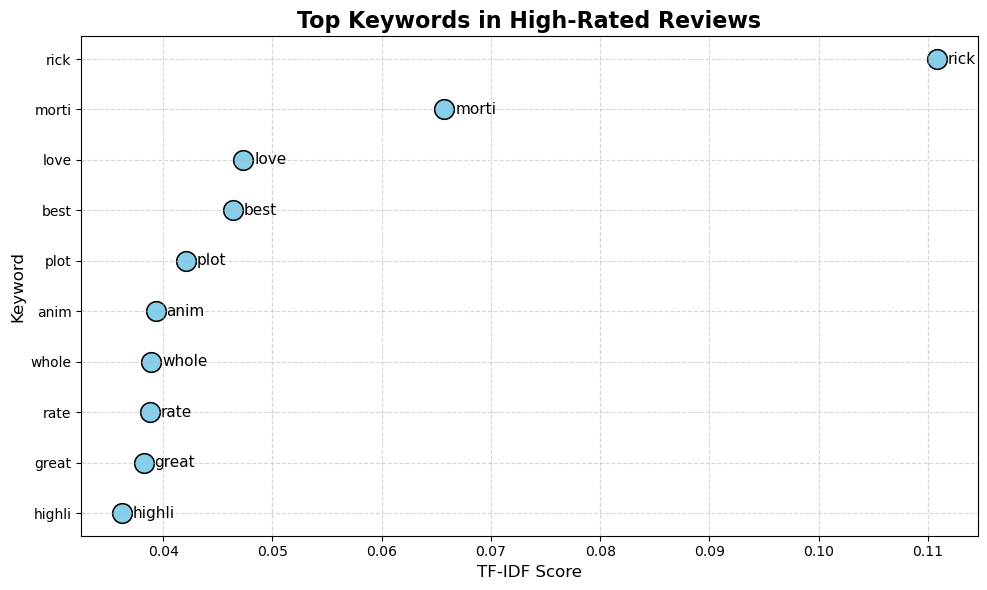

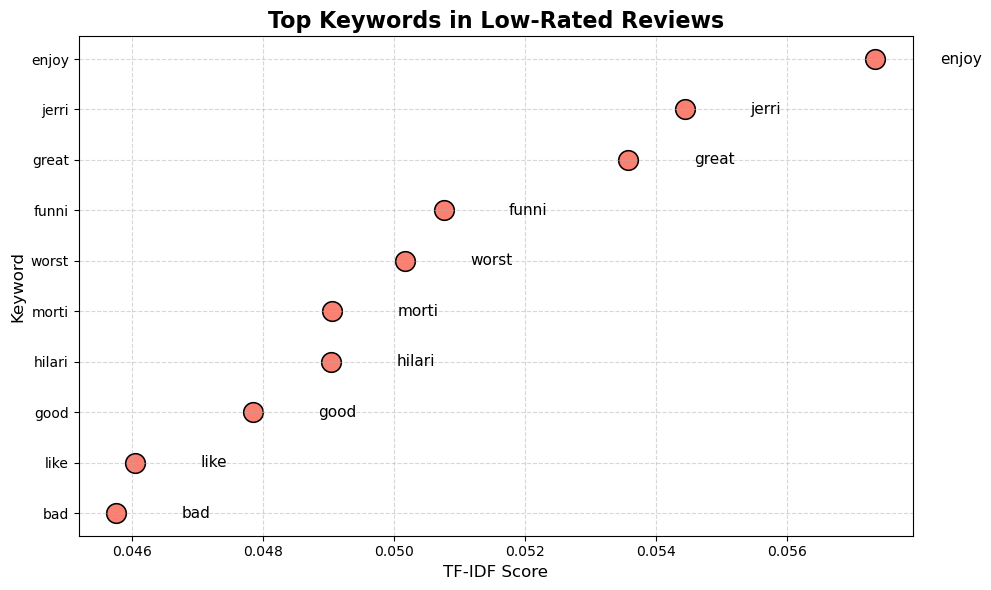

In [64]:
# High-Rated Reviews
plot_keywords_scatter(keywords_high, "Top Keywords in High-Rated Reviews", color='skyblue')

# Low-Rated Reviews 
plot_keywords_scatter(keywords_low, "Top Keywords in Low-Rated Reviews", color='salmon')


In [42]:
# Perform topic modeling using Non-negative Matrix Factorization (NMF)
from sklearn.decomposition import NMF

# Apply TF-IDF to the full dataset
tfidf = TfidfVectorizer(max_features=500)
X_topics = tfidf.fit_transform(df["cleaned"])

# Fit NMF model
nmf = NMF(n_components=5, random_state=42)
topic_matrix = nmf.fit_transform(X_topics)

# Display top keywords in each topic
topic_keywords = pd.DataFrame(nmf.components_, columns=tfidf.get_feature_names_out())
for i, topic in topic_keywords.iterrows():
    print(f"\nNMF Topic {i+1}:")
    print(", ".join(topic.sort_values(ascending=False).head(10).index))



NMF Topic 1:
rick, morti, charact, april, alreadi, probabl, fan, day, littl, new

NMF Topic 2:
jerri, funni, good, hospit, end, peni, person, space, worst, mean

NMF Topic 3:
plot, yet, anim, took, long, give, far, great, twist, without

NMF Topic 4:
best, whole, love, compar, anyth, anim, better, episod, exactli, joke

NMF Topic 5:
enjoy, hilari, rate, sequel, great, interdimension, cabl, favourit, deserv, lowest


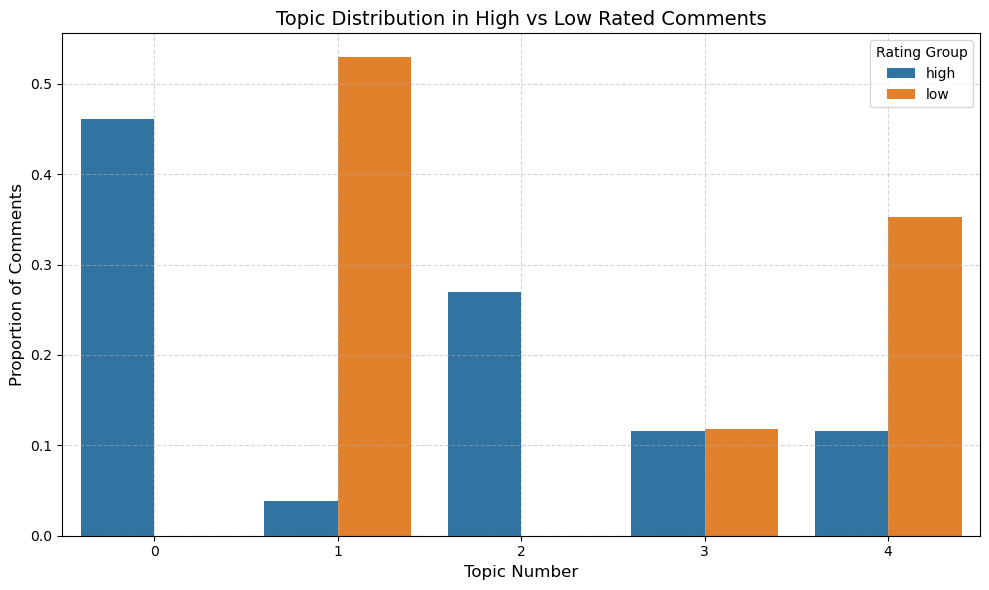

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# use current NMF outcome to conduct topic_matrix
df['main_topic'] = topic_matrix.argmax(axis=1)  
# Count how many comments in each rating group are assigned to each topic
topic_distribution = df.groupby(['group', 'main_topic']).size().reset_index(name='count')

# Then calculate the proportion of each topic within the high/low group
total_per_group = df['group'].value_counts().to_dict()
topic_distribution['percent'] = topic_distribution.apply(
    lambda row: row['count'] / total_per_group[row['group']], axis=1
)

# visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=topic_distribution, x='main_topic', y='percent', hue='group')
plt.title("Topic Distribution in High vs Low Rated Comments", fontsize=14)
plt.xlabel("Topic Number", fontsize=12)
plt.ylabel("Proportion of Comments", fontsize=12)
plt.legend(title="Rating Group")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



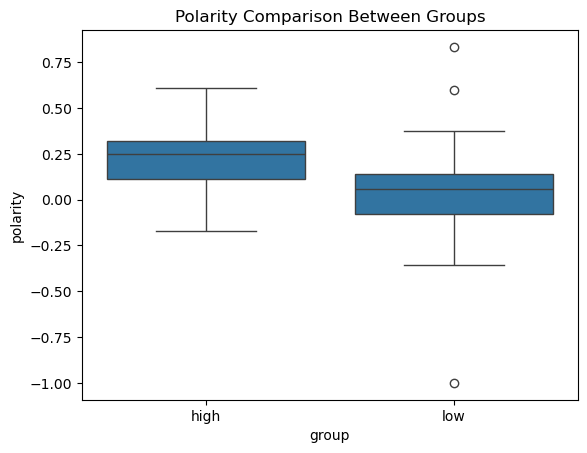

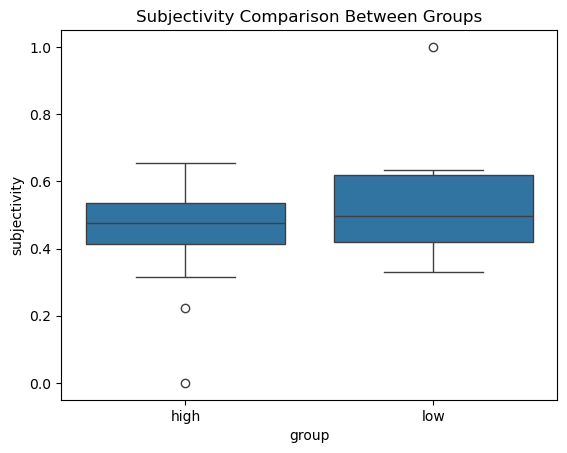

In [44]:
# Visualize sentiment polarity and subjectivity using boxplots
import seaborn as sns

# Boxplot: Polarity comparison
sns.boxplot(data=df, x="group", y="polarity")
plt.title("Polarity Comparison Between Groups")
plt.show()

# Boxplot: Subjectivity comparison
sns.boxplot(data=df, x="group", y="subjectivity")
plt.title("Subjectivity Comparison Between Groups")
plt.show()
